In [5]:
import os

os.environ['backend'] = "numpy"

import matplotlib.pyplot as plt

from psfit.module import MSELoss, Linear
from psfit.optim import LocalTrainer, SGD, ProjectionSparsifier
from psfit.optim.optimizer import Admm

from psfit.data import RandomRegressionDataset, DataLoader
import seaborn as sns
import numpy as np

### Dataset Creation and DataLoader Initialization

In this section, we will create a synthetic dataset for regression analysis using a custom class `RandomRegressionDataset`. This dataset will have a specific number of samples and features, which allows us to simulate various regression scenarios.

- **Parameters**:
  - `m`: This variable represents the number of samples in the dataset.
  - `n`: This variable represents the number of features for each sample.
  - `variance`: The variance of the generated data points. A lower value indicates that the data points will be closer to the true regression line, while a higher value will spread them out. We set it to `0.01` for this simulation.

Next, we initialize the `DataLoader` with the following key parameters:
- `dataset`: This is the dataset we just created using `RandomRegressionDataset`.
- `batch_size`: This determines how many samples will be included in each batch during training. We set it equal to `m` to use all samples in one batch.
- `shuffle`: This parameter, when set to `True`, ensures that the data is shuffled before being loaded, which helps in training the model effectively by providing a varied input order.
- `report`: When set to `True`, this option might enable logging or reporting features in the DataLoader, allowing us to track the loading process.

The following code implements this setup:


In [7]:
m, n = 1000, 500  # samples and features

dataset = RandomRegressionDataset(m, n, variance = 0.1)
w_true = np.random.randn(n, 1)
dataset.populate(w_true = w_true)

loader = DataLoader(dataset = dataset, batch_size = m, shuffle = True, report = True)


Loading batches to cpu

Number of batches loaded: 1


### Model Initialization and Training Setup

In this section, we will initialize a linear regression model and set up a training process using a custom `ModelTrainer` class. We will also define an optimization strategy using the Alternating Direction Method of Multipliers (ADMM).

1. **Model Initialization**:
   - We create an instance of `LinearRegression`, specifying `in_features` as `n`, which represents the number of features in our dataset (set to `5`). This model will learn the linear relationship between the input features and the target variable.

2. **Trainer Initialization**:
   - We then initialize the `ModelTrainer` with the following parameters:
     - `dataloader`: This is the `loader` we created earlier, which provides batches of data for training.
     - `loss`: We use the Mean Squared Error (MSE) loss function, which is commonly used for regression tasks to measure the average squared difference between the predicted and actual values.
     - `optimizer`: We employ the Stochastic Gradient Descent (SGD) optimizer, specifying the `model` we created and setting the `learning_rate`. This optimizer will adjust the model's parameters based on the gradients computed from the loss function during training.

3. **Optimizer Initialization**:
   - We define an optimization strategy using the `Admm` class:
     - `trainer`: This parameter links the ADMM optimizer to our previously defined `trainer`.
     - `aggregator`: We utilize a `ProjectionSparsifier`, which helps in enforcing sparsity in the model updates. The `density` parameter is set to indicate that we want to keep only a subset of the most significant parameters during each update.

The following code implements this model and training setup:


In [10]:
model = Linear(in_features = n, out_features = 1)

trainer = LocalTrainer(
    dataloader = loader,
    loss = MSELoss(),
    optimizer = SGD(model, learning_rate = 0.01),
    verbose = False
)

optimizer = Admm(
    trainer = trainer,
    aggregators = ProjectionSparsifier(density = 100)
)


### Training Loop and Loss Tracking

In this section, we will implement the training loop for our linear regression model using the previously defined optimizer. We will run the training for a total of 100 epochs and track the loss and error metrics throughout the process.

1. **Loss Initialization**:
   - We begin by initializing an empty list called `losses` to store the loss values computed during each epoch of training.

2. **Training Loop**:
   - We run a loop for `100` epochs, which represents the number of iterations over the entire dataset. In each epoch:
     - We call the `step` method of the `optimizer`, passing a `penalty` parameter set to `1`. This method performs the optimization step, updating the model's parameters based on the current gradients and returning the computed loss and error values.
     - We append the computed loss to the `losses` list to keep a record of how the loss evolves over time.

3. **Logging Progress**:
   - Every 20 epochs, we print the current epoch number along with the corresponding loss and error values. The output format ensures that the epoch number is displayed as a three-digit integer and the loss and error values are formatted to four and six decimal places, respectively. This logging helps in monitoring the model's training progress and understanding its convergence behavior.

The following code implements this training loop:


In [12]:

losses = []

for epoch in range(200):

    loss, err = optimizer.step(penalty = 10)

    losses.append(loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1:3d}: Loss = {loss:.4f}, Error = {err:.6f}")

Epoch  20: Loss = 158.2202, Error = 0.000013
Epoch  40: Loss = 158.0664, Error = 0.000001
Epoch  60: Loss = 158.0483, Error = 0.000000
Epoch  80: Loss = 158.0457, Error = 0.000000
Epoch 100: Loss = 158.0453, Error = 0.000000
Epoch 120: Loss = 158.0452, Error = 0.000000
Epoch 140: Loss = 158.0452, Error = 0.000000
Epoch 160: Loss = 158.0452, Error = 0.000000
Epoch 180: Loss = 158.0451, Error = 0.000000
Epoch 200: Loss = 158.0451, Error = 0.000000


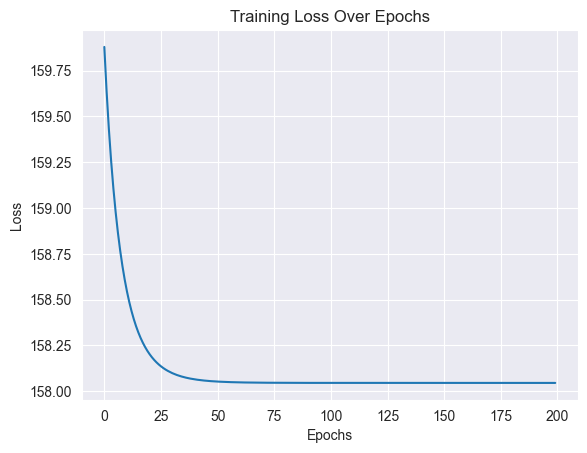

In [13]:

# Plot the losses
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

<Axes: ylabel='Count'>

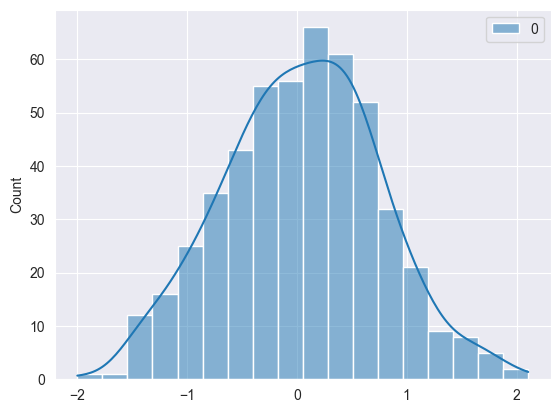

In [18]:
residual = w_true - model.weights.array()
sns.histplot(residual, kde = True)